# A-B Testing

Firstly I want to add some useful resources to it:
- https://blog.duolingo.com/improving-duolingo-one-experiment-at-a-time/ 
- https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing

The first link Explain why A/B test are useful for Duolingo, the second link is more of what I am going to do here. 
I also added the second link because probably I will use some of the code use there to do the analysis and I think it is  respecful to put the link of the actual source :) 

So first of all A/B test it is just a way to test if two group has a difference in a target or targets value. Generally, there is a control group and a group that experience some "new treatment" that we want to test.
There is a very common test that is the **T-test** that you may be wondering why we just don't use that test and we test exactly that. The problem with that particular test is it has **some assumption that need to be fulfill** Those assumption are:
1) The groups that are we comparing the target comes from a normal distribution
2) The groups have the same variance.

Pretty big assumption if you ask me!, especially the last one (we can have the first one thanks for the CLT (central limit theorem). 

So if we want to use this test we need to check both of these requierement. So we need to:
1) test normality with a test, we will use Shapiro test.
2) Use Leve Test for test homogeneity of variance (equal variance)

If and only if we have a check in both assumption we use the T-test.
If (1) is true but (2) is not true (using Levene test) We use Welch Test.
If (1) is not true we directly jump to use Mann Whitney U Test.

There is some veeery interesting debate on this test that I highly recommend you to read more in case you want to know more about this tests (I would recommend to read them in the order presented!):

- https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless
- https://stats.stackexchange.com/questions/121852/how-to-choose-between-t-test-or-non-parametric-test-e-g-wilcoxon-in-small-sampl
- https://stats.stackexchange.com/questions/151663/normality-and-when-to-use-t-test-vs-mann-whitney-u-test

Some interesting concepts that you may encounter there and are interesting to ponder about:
+ Power vs Robustness
+ skew vs kurtotic and how impact inference about mean vs variance
+ What happened to this assumption for n small, large or very large. Other important topics on the same line: CLT and small variation on the normal distribution and Saphiro test.


We will use the same data that use the second link: https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/input

In [1]:
# !pip install pandasql

In [2]:
import plotly.io as pio
pio.renderers.default = "svg"

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import pandasql as ps
# testing normality
from scipy.stats import shapiro
# plotting Q-Q: testing normality with a graph
import scipy.stats as stats
import pylab 
import statsmodels.api as sm

Looking here https://www.kaggle.com/code/yufengsui/datacamp-project-mobile-games-a-b-testing/notebook We have this explanation for the variables:

The data is from **90,189 players** that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [4]:
cat_df = pd.read_csv(
    'cookie_cats.csv'
)
print(f"shape df: {cat_df.shape}")
cat_df.head()


shape df: (90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Some quick analysis
cat_df.isnull().any()
# We do not have null, so we do not need to impute results :)

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

In [6]:
# notice we have three differents metrics to explore
cat_df['retention_1'] = cat_df['retention_1'].apply(lambda x: 1 if x else 0)
cat_df['retention_7'] = cat_df['retention_7'].apply(lambda x: 1 if x else 0)
print(f"version there are: {cat_df['version'].unique()}")
cat_df['version'] = cat_df['version'].apply(lambda x: "A" if x=="gate_30" else "B")
cat_df['counter'] = 1
cat_df.head(4)

version there are: ['gate_30' 'gate_40']


,userid,version,sum_gamerounds,retention_1,retention_7,counter
0,116,A,3,0,0,1
1,337,A,38,1,0,1
2,377,B,165,1,0,1
3,483,B,1,0,0,1


# Basic graph to understand our Data

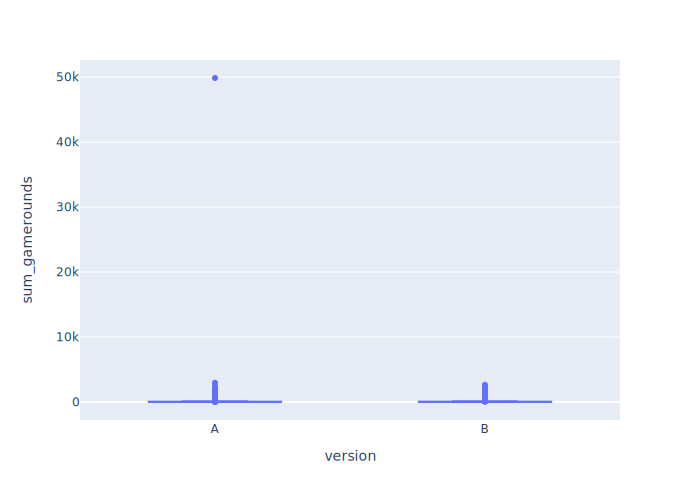

In [7]:
fig = px.box(cat_df, y="sum_gamerounds", x="version")
fig.show()

In [8]:
# We have an outlier we are going to take out!
cat_df.drop(cat_df[cat_df['sum_gamerounds']>10000].index,inplace=True,axis=0)

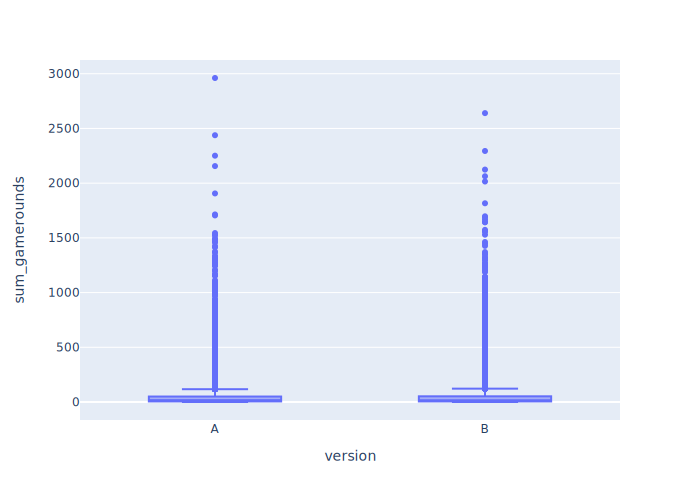

In [9]:
fig = px.box(cat_df, y="sum_gamerounds", x="version")
fig.show()

We could also take outliers out with: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html and choosing points that are too far away from the mean giving the standard deviation.

# Big table review

In [10]:
# I could just use groupby in pandas but I prefer "defaulting" to SQL whenever possible
query = f"""

SELECT version, 
SUM(sum_gamerounds) as sum_gamerounds,
SUM(retention_1) as sum_retention_1,
SUM(retention_7) as sum_retention_7,
SUM(counter) as number_of_register
FROM cat_df
GROUP BY version
;
"""

result_df = ps.sqldf(query, locals()).reset_index(drop=True)
result_df['mean_gamerounds'] = result_df['sum_gamerounds']/result_df['number_of_register'] 
result_df['mean_retention_1_percentage'] = result_df['sum_retention_1']*100/result_df['number_of_register'] 
result_df['mean_retention_7_percentage'] = result_df['sum_retention_7']*100/result_df['number_of_register'] 
result_df.drop(columns=['sum_gamerounds','sum_retention_1','sum_retention_7'],axis=1, inplace=True)

In [11]:
result_df

,version,number_of_register,mean_gamerounds,mean_retention_1_percentage,mean_retention_7_percentage
0,A,44699,51.342111,44.819795,19.018323
1,B,45489,51.298776,44.228275,18.200004


We can see on the spot that version A aka gate_30 is a little better than version B in all parameters, but is this difference due to change or is significant, that it is what we will try to find out!

# Doing the actual test on the data
## Checking Normality

In [12]:
# Split A/B
group_A = cat_df[cat_df['version'] == "A"]['sum_gamerounds']
group_B = cat_df[cat_df['version'] == "B"]['sum_gamerounds']
group_A

0         3
1        38
6         0
11        0
13       39
         ..
90179    14
90180     7
90182    21
90183    10
90186    28
Name: sum_gamerounds, Length: 44699, dtype: int64

In [13]:
shapiro(group_A)

C:\Users\Rober\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



ShapiroResult(statistic=0.4886430501937866, pvalue=0.0)

Here is important to notice two things:
+ The important piece of information is the p-value: which in this case is extremely small, we conclude that we reject the null hypothesis (P value is in short the probability that the null hipothesis is correct)
+ The own libraries advise us that for small variation in the normality function the test can reject normality. 

So what are we going to do? simple Let us plot the Q-Q graph and see if we see a line!

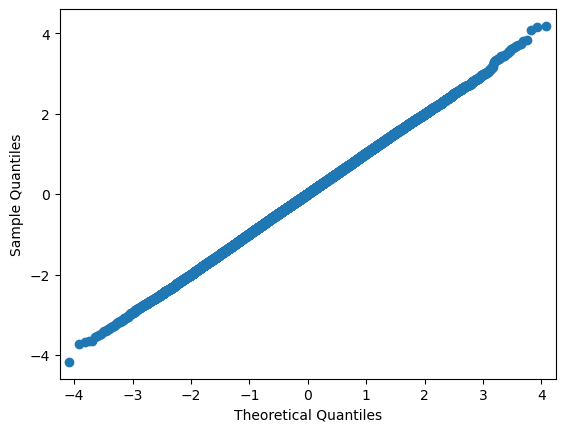

In [14]:
# This is how it looks a normal distribution in a qqplot
test = np.random.normal(0,1, len(group_A))
sm.qqplot(test)
pylab.show()

So it is just a line when we do the QQ plot!

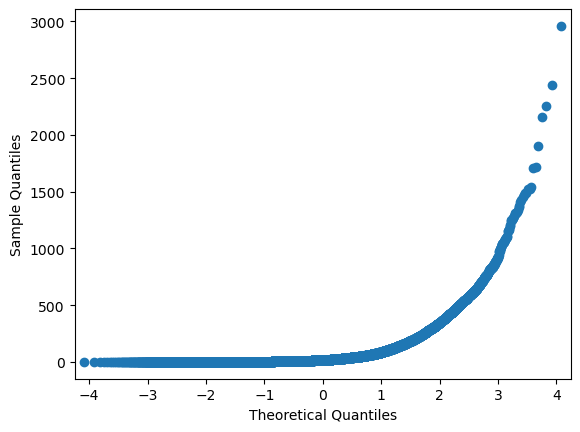

In [15]:
sm.qqplot(group_A)
pylab.show()

As we can see the data is clearly not normal! There are too many values that are 0, so it is extremely skew towards 0 (is not simitrical towards the mean). So in conclusion, plotting with Q-Q and comparing to a normal distribution we found out our function differ considerabily from a normal distribution. So the saphire and the graph show that we cannot assume that the data distribute like a normal distribution.

Another cool thing we could do, It is to check weather those two groups come from the same distribution

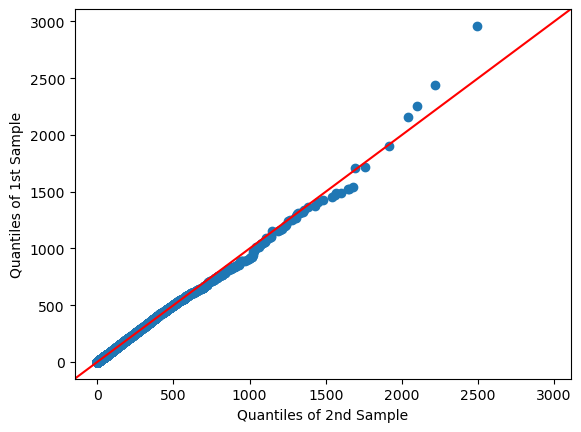

In [16]:
sm.qqplot_2samples(group_A,group_B,line='45')
pylab.show()

Well both distribution looks roughly the same (that is what we would expect)! 
Notice this says nothing about the mean of each distribution, it just states that the underlying probability function is roughly the same.

Look at the example below, we are going to plot two normal distribution one with a mean of 20 and 10 times more standard deviation and it will produce a line too!

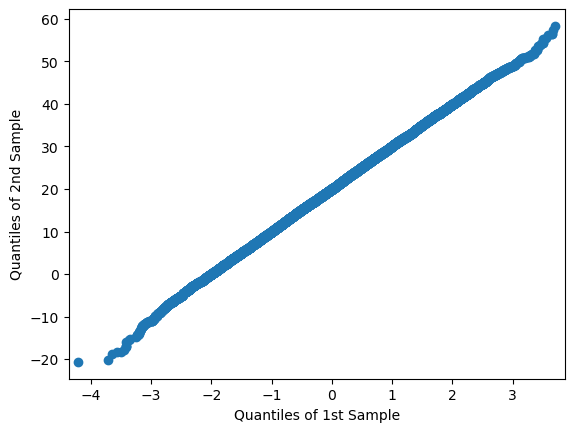

In [17]:
test1 = np.random.normal(0,1, len(group_A))
test2 = np.random.normal(20,10, len(group_A))
sm.qqplot_2samples(test1,test2)
pylab.show()

## Using a non-parametric test

In [18]:
ttest = stats.mannwhitneyu(group_A, group_B,alternative='two-sided')[1]
ttest

0.05089155279145376

I use two-sided testing because I do not have any reason to believe that one version is better than the other!!

So, we were so close to rejecting the null hipothesis, but we can't reject the null hipothesis so the difference between both group is not significant (in that particular target).

Just for curious, I am going to test what would have been the result if the data were normal (that we know that isn't the case) with the same variance (I will test a t-student but it is just for fun!)

In [19]:
stats.ttest_ind(group_A, group_B, equal_var=True)[1]

0.9494739458256001

Well this function state even harder that the two means are identical.